In [317]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.dates import DateFormatter
from matplotlib import pyplot
from scipy import signal
from matplotlib.ticker import AutoMinorLocator
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor

import warnings

warnings.filterwarnings("ignore")

## Data Cleaning

In [1]:
# Transform data to workable format
# Replace , with .
# Round to theree decimals
data = pd.read_csv('LD2011_2014.txt', sep=';')

data = data.rename(columns={'Unnamed: 0': 'Time'})

for i in range(1,362):
    data[data.columns[i]] = data[data.columns[i]].str.replace(',', '.')
for i in range(363,371):
    data[data.columns[i]] = data[data.columns[i]].str.replace(',', '.')
    
data[data.columns[1:371]] = data[data.columns[1:371]].astype(float)

data = data.round(3)

data = data.fillna(0)

data.to_csv("data.csv")

## Read in Data

In [29]:
# Create a new column 'avg' as target variable
df = pd.read_csv('data.csv', index_col=0)
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df = df.replace(0,np.NaN)
col = df.loc[: , "MT_001":"MT_370"]
df['avg'] = col.mean(axis=1, skipna=True)
df

,Time,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,avg
0,2011-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,433.627323
1,2011-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,437.850038
2,2011-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,439.018019
3,2011-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,432.598000
4,2011-01-01 01:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,418.777652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140251,2014-12-31 23:00:00,2.538,22.048,1.738,150.407,85.366,303.571,11.306,282.828,68.182,...,28200.0,1616.034,1363.636,29.987,5.851,697.103,176.962,651.026,7621.622,360.459828
140252,2014-12-31 23:15:00,2.538,21.337,1.738,166.667,81.707,324.405,11.306,252.525,64.685,...,28300.0,1569.620,1340.909,29.987,9.947,671.642,168.614,669.355,6702.703,351.211784
140253,2014-12-31 23:30:00,2.538,20.626,1.738,162.602,82.927,318.452,10.175,242.424,61.189,...,27800.0,1556.962,1318.182,27.379,9.362,670.764,153.589,670.088,6864.865,348.301142
140254,2014-12-31 23:45:00,1.269,21.337,1.738,166.667,85.366,285.714,10.175,225.589,64.685,...,28000.0,1443.038,909.091,26.076,4.096,664.618,146.912,646.628,6540.541,342.347981



## EDA


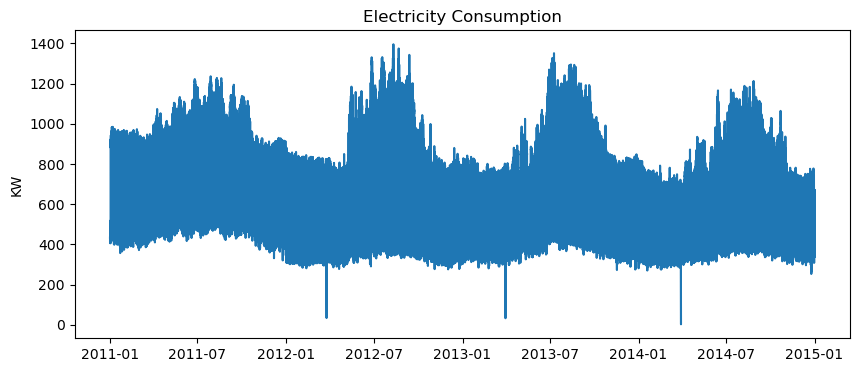

In [298]:
# Time Series over Time
plt.subplots(figsize=(10, 4))
plt.plot(df.Time, df.avg)
plt.title('Electricity Consumption')
plt.ylabel('KW')
plt.show()

In [299]:
# Check for outliers
# Turned out to be Earth Hour
df.query("avg<250")["Time"]

43107    2012-03-25 01:00:00
43108    2012-03-25 01:15:00
43109    2012-03-25 01:30:00
43110    2012-03-25 01:45:00
78723    2013-03-31 01:00:00
78724    2013-03-31 01:15:00
78725    2013-03-31 01:30:00
78726    2013-03-31 01:45:00
113667   2014-03-30 01:00:00
113668   2014-03-30 01:15:00
113669   2014-03-30 01:30:00
113670   2014-03-30 01:45:00
Name: Time, dtype: datetime64[ns]

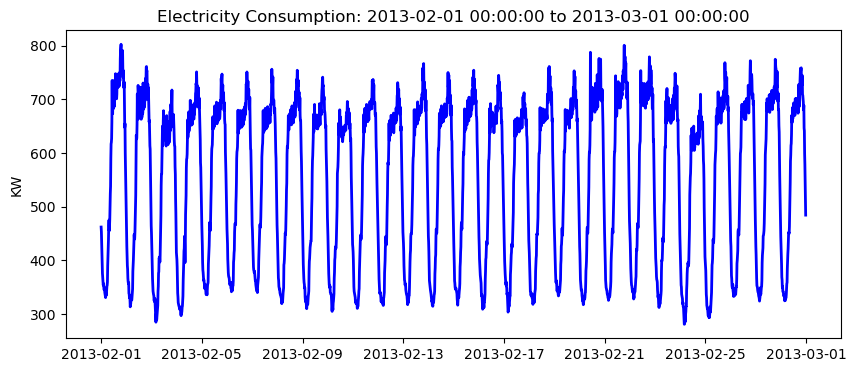

In [300]:
# Time Series for a specific month
start = df[df['Time'] == '2013-02-01 00:00:00'].index.tolist()[0]
end = df[df['Time'] == '2013-03-01 00:00:00'].index.tolist()[0]
plt.subplots(figsize=(10, 4))
plt.plot(df.Time[start:end], df.avg[start:end], color='blue', linewidth=2)
plt.title('Electricity Consumption: 2013-02-01 00:00:00 to 2013-03-01 00:00:00')
plt.ylabel('KW')
plt.show()

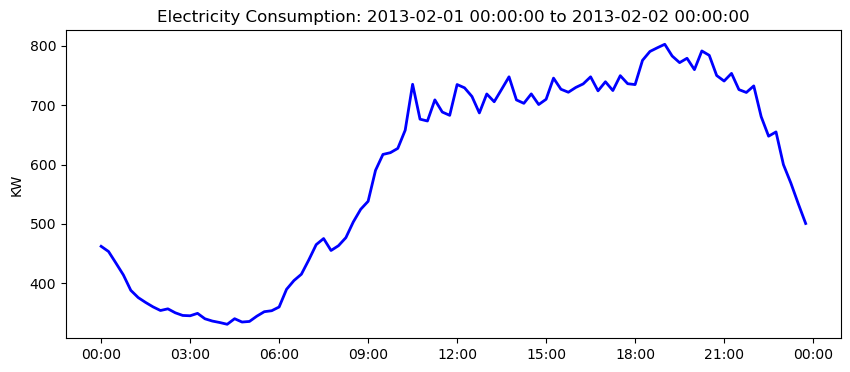

In [301]:
# Time Series for a specific day
start = df[df['Time'] == '2013-02-01 00:00:00'].index.tolist()[0]
end = df[df['Time'] == '2013-02-02 00:00:00'].index.tolist()[0]
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(df.Time[start:end], df.avg[start:end], color='blue', linewidth=2)
plt.title('Electricity Consumption: 2013-02-01 00:00:00 to 2013-02-02 00:00:00')
plt.ylabel('KW')
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
plt.show()

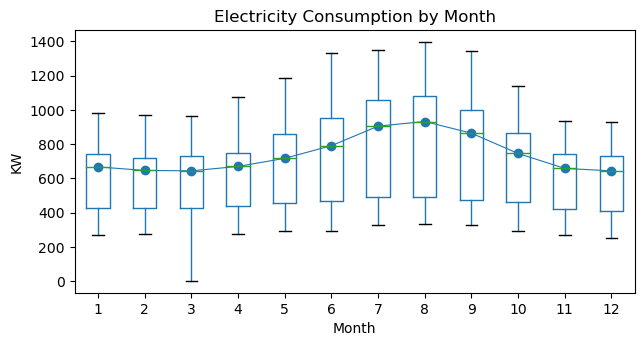

In [302]:
# Electricity Consumption by Month
fig, ax = plt.subplots(figsize=(7, 3.5))
df['month'] = df.Time.dt.month
df.boxplot(column='avg', by='month', ax=ax,)
df.groupby('month')['avg'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('KW')
ax.set_xlabel('Month')
ax.set_title('Electricity Consumption by Month')
fig.suptitle('');
plt.show()

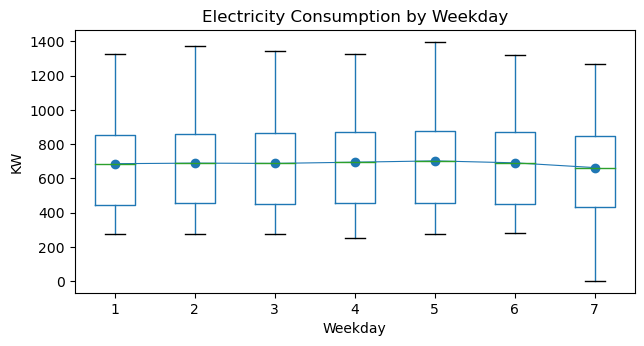

In [303]:
# Electricity Consumption by Weekday
fig, ax = plt.subplots(figsize=(7, 3.5))
df['week_day'] = df.Time.dt.day_of_week + 1
df.boxplot(column='avg', by='week_day', ax=ax)
df.groupby('week_day')['avg'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('KW')
ax.set_xlabel('Weekday')
ax.set_title('Electricity Consumption by Weekday')
fig.suptitle('');
plt.show()

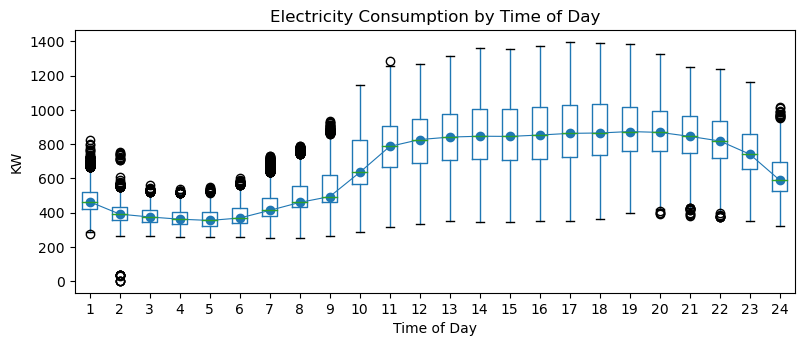

In [304]:
# Electricity Consumption by Time of Day
fig, ax = plt.subplots(figsize=(9, 3.5))
df['hour_day'] = df.Time.dt.hour + 1
df.boxplot(column='avg', by='hour_day', ax=ax)
df.groupby('hour_day')['avg'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('KW')
ax.set_xlabel('Time of Day')
ax.set_title('Electricity Consumption by Time of Day')
fig.suptitle('');
plt.show()

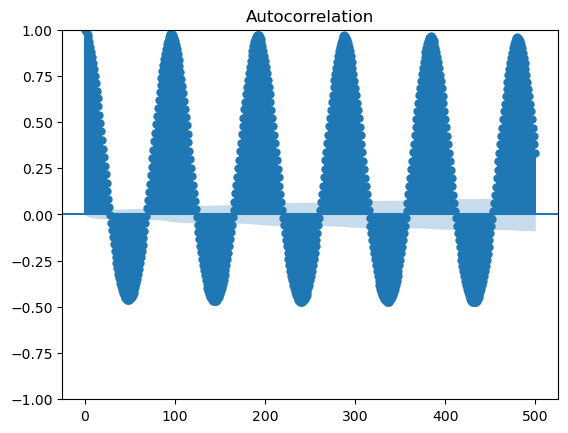

In [105]:
# Autocorrelation
dft = df.transpose()
dft.columns = dft.iloc[0]
dft = dft[1:]
avg = dft.loc['avg']
plot_acf(avg,lags=500)
pyplot.show()

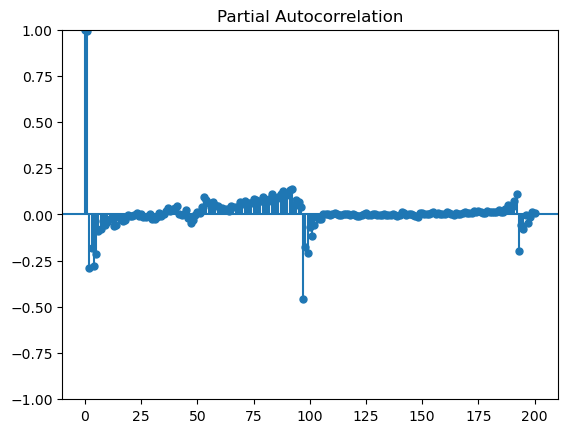

In [106]:
# Partial Autocorrelation
plot_pacf(avg, lags=200)
pyplot.show()

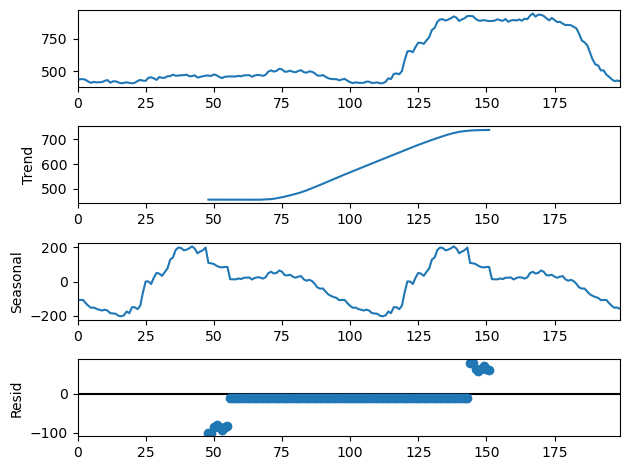

In [307]:
# Seasonal Decomposition
df_= pd.DataFrame().assign(Average=df.avg)[:200]
result = seasonal_decompose(df_, period=96)
result.plot()
plt.show()

## Data Processing

In [30]:
# Group by Day
df = df.set_index('Time')
df = df.resample(rule='d', closed='left', label ='left').sum()
df

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,avg
Time,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,43373.268715
2011-01-02,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70514.848025
2011-01-03,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,71970.270479
2011-01-04,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,73404.200504
2011-01-05,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,73777.216610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28,227.151,2131.585,151.205,14327.233,6776.831,20122.021,429.609,25255.867,5118.886,4794.625,...,3272100.0,220721.522,257477.275,8169.498,552.377,45914.835,4405.676,66135.629,1553189.192,51687.062383
2014-12-29,248.724,2212.666,160.763,14067.074,7198.791,22824.405,550.589,30286.168,6697.560,6337.636,...,3109100.0,206852.327,269090.907,8438.078,1153.896,53928.888,12914.857,73882.700,1806486.488,53141.894339
2014-12-30,232.227,2205.553,165.108,14290.653,7189.024,23880.952,586.769,30909.065,6487.765,6489.248,...,2904300.0,204126.583,263613.633,10615.392,892.339,56334.499,15996.663,73950.145,1867567.567,53187.781005


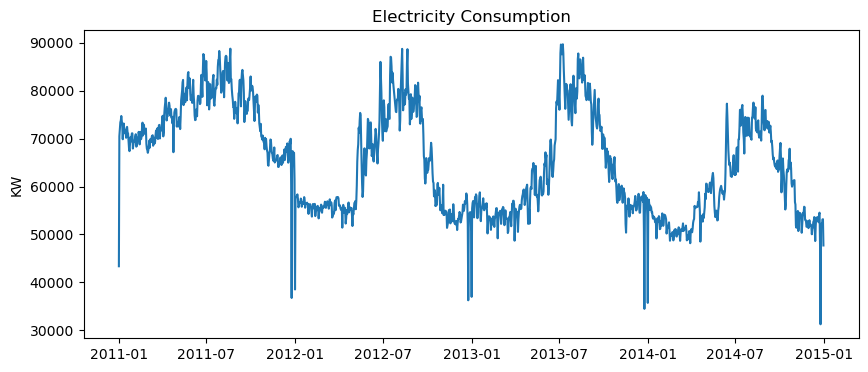

In [31]:
# Time Series
plt.subplots(figsize=(10, 4))
plt.plot(df.index[:-1], df.avg[:-1])
plt.title('Electricity Consumption')
plt.ylabel('KW')
plt.show()

In [32]:
# Check for outliers
df.loc[df['avg'] < 45000].index

DatetimeIndex(['2011-01-01', '2011-12-25', '2012-01-01', '2012-12-25',
               '2013-01-01', '2013-12-25', '2014-01-01', '2014-12-25',
               '2015-01-01'],
              dtype='datetime64[ns]', name='Time', freq=None)

In [33]:
# Add Holiday
first = str(df.first('1D').index.date[0])
last = str(df.last('1D').index.date[0])
cal = USFederalHolidayCalendar()
hol = cal.holidays(start=first, end=last)
df['Holiday'] = np.where(
    df.index.to_period('D').astype('datetime64[ns]').isin(hol),
    1, 0
)
df.loc['2011-01-01', 'Holiday']=1
df.loc['2012-01-01','Holiday']=1
df.loc['2011-12-25','Holiday']=1

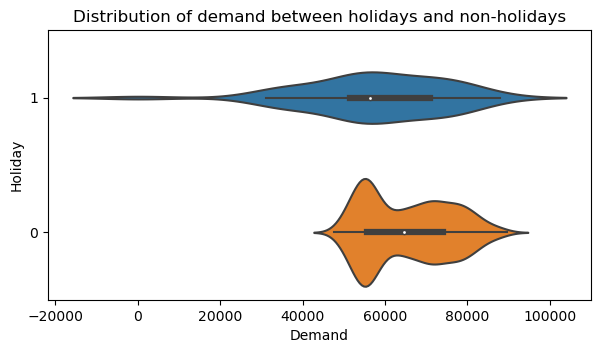

In [34]:
# Plot for Distribution of Demand between Holidays and Non-holidays
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'avg',
    y       = 'Holiday',
    data    = df.assign(Holiday = df.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of demand between holidays and non-holidays')
ax.set_xlabel('Demand')
ax.set_ylabel('Holiday');
plt.show()

In [35]:
df

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,avg,Holiday
Time,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,43373.268715,1
2011-01-02,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70514.848025,0
2011-01-03,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,71970.270479,0
2011-01-04,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,73404.200504,0
2011-01-05,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,73777.216610,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28,227.151,2131.585,151.205,14327.233,6776.831,20122.021,429.609,25255.867,5118.886,4794.625,...,220721.522,257477.275,8169.498,552.377,45914.835,4405.676,66135.629,1553189.192,51687.062383,0
2014-12-29,248.724,2212.666,160.763,14067.074,7198.791,22824.405,550.589,30286.168,6697.560,6337.636,...,206852.327,269090.907,8438.078,1153.896,53928.888,12914.857,73882.700,1806486.488,53141.894339,0
2014-12-30,232.227,2205.553,165.108,14290.653,7189.024,23880.952,586.769,30909.065,6487.765,6489.248,...,204126.583,263613.633,10615.392,892.339,56334.499,15996.663,73950.145,1867567.567,53187.781005,0


In [43]:
# Group data by Week
df = df.resample(rule='W-Sat', closed='left', label ='left').sum()
df = df[:-1]

In [44]:
df

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,avg,Holiday
Time,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000e+00,481527.477720,1
2011-01-08,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000e+00,502951.345669,0
2011-01-15,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000e+00,498078.529789,1
2011-01-22,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000e+00,485628.908587,0
2011-01-29,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000e+00,486920.453124,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-22,1431.432,15495.055,1150.529,85875.982,39807.318,136717.273,3111.885,172531.814,35543.749,45292.476,...,1512936.710,2219840.927,51289.413,6778.838,381738.357,83380.628,513220.675,1.177692e+07,370590.632546,1
2014-11-29,1398.438,15648.680,1150.529,88241.860,41308.538,141267.868,3157.081,174073.900,36101.454,40534.392,...,1486987.347,1788977.278,52091.282,7004.665,376708.519,86247.081,505414.208,1.193795e+07,364544.260878,0
2014-12-06,1407.321,15445.965,1150.529,93160.551,46463.447,153059.528,3500.250,180164.805,39653.890,42175.268,...,1467649.794,1640249.998,53182.573,6377.428,363973.654,82808.008,503136.374,1.206768e+07,363506.206518,0


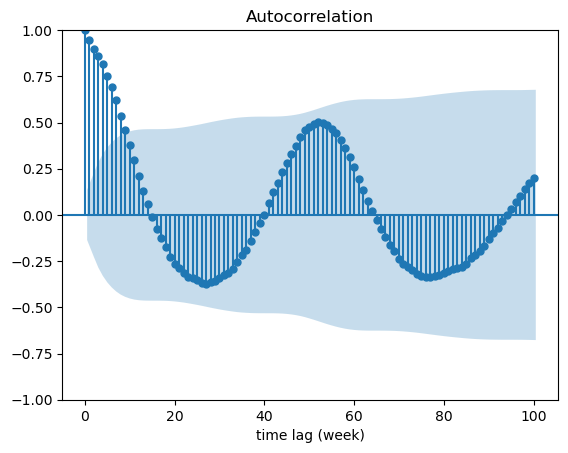

In [45]:
# Auto Correlation
plot_acf(df.avg,lags=100)
pyplot.xlabel("time lag (week)")
pyplot.show()

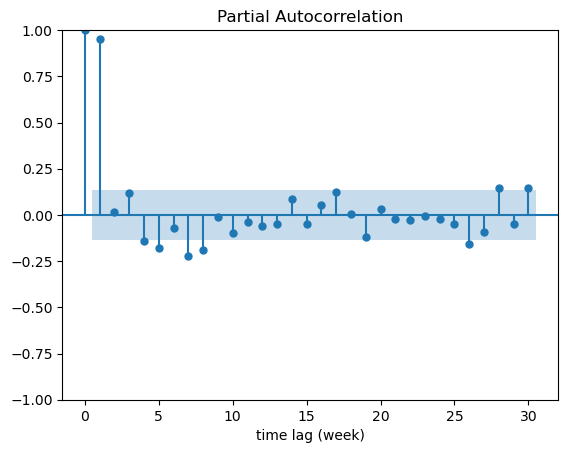

In [46]:
# Partial Auto Correlation
plot_pacf(df.avg, lags=30)
pyplot.xlabel("time lag (week)")
pyplot.show()

<Figure size 1000x700 with 0 Axes>

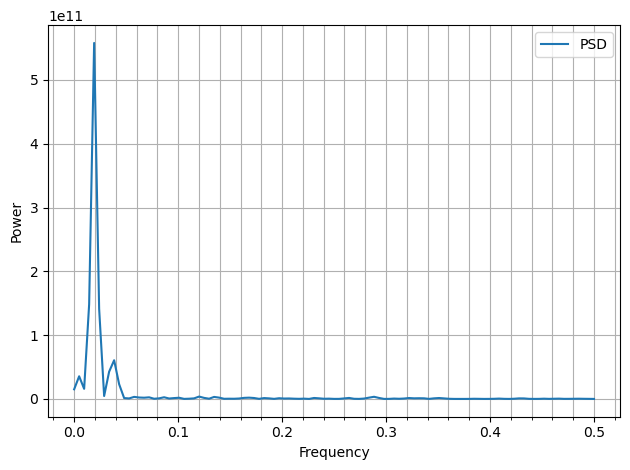

In [47]:
#PSD
freqs, psd = signal.welch(df.avg)
plt.figure(figsize=(10, 7))
fig, ax = plt.subplots()
ax.plot(freqs, psd)
minor_locator = AutoMinorLocator(5)
ax.xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')
plt.legend(['PSD'])
plt.xlabel('Frequency')
plt.ylabel('Power')
ax.grid(True, which='both')
plt.tight_layout()
plt.show()

In [48]:
# Differencing
df['lag1'] = df['avg'].diff()

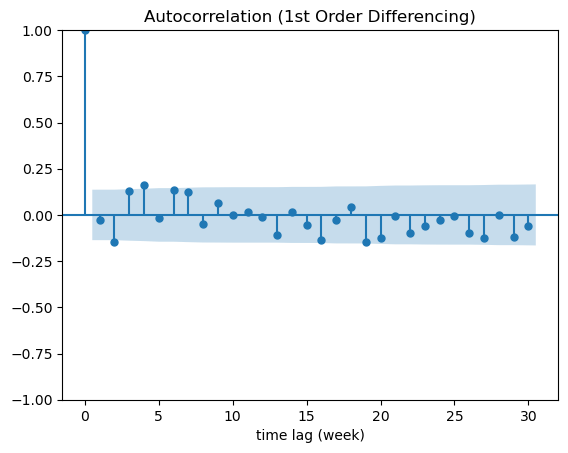

In [49]:
# Auto Correlation for Differencing
plot_acf(df.lag1[1:-1],lags=30)
pyplot.xlabel("time lag (week)")
pyplot.title("Autocorrelation (1st Order Differencing)")
pyplot.show()

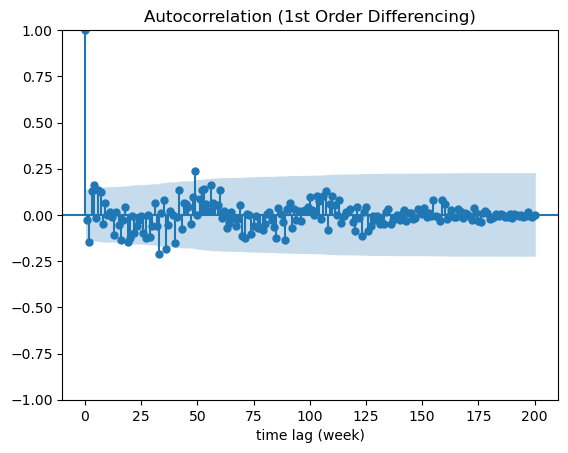

In [116]:
# Auto Correlation for Differencing
plot_acf(df.lag1[1:-1],lags=200)
pyplot.xlabel("time lag (week)")
pyplot.title("Autocorrelation (1st Order Differencing)")
pyplot.show()

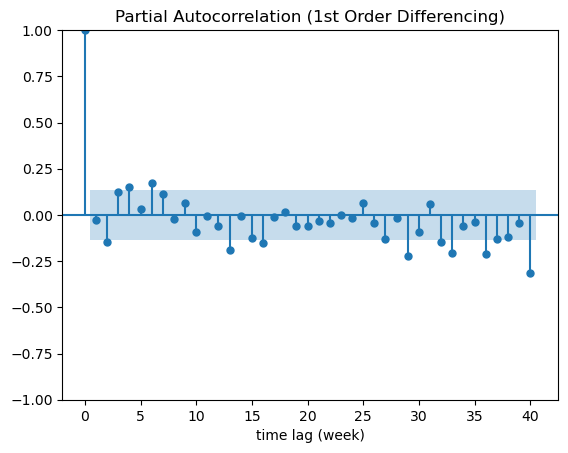

In [50]:
# Partial Auto Correlation for Differencing
plot_pacf(df.lag1[1:-1], lags=40)
pyplot.xlabel("time lag (week)")
pyplot.title("Partial Autocorrelation (1st Order Differencing)")
pyplot.show()

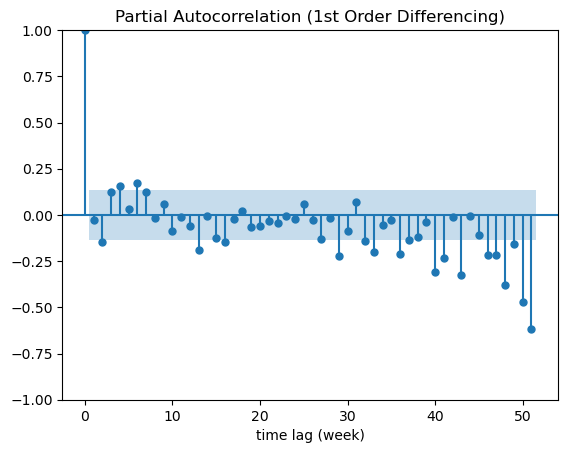

In [247]:
# Partial Auto Correlation for Differencing
plot_pacf(df.lag1[1:], lags=51)
pyplot.xlabel("time lag (week)")
pyplot.title("Partial Autocorrelation (1st Order Differencing)")
pyplot.show()

In [51]:
# 2nd order Differencing
df['lag1'] = df['avg'] - df['avg'].shift(1)
df['lag2'] = df['avg'] - 2*df['avg'].shift(1) + df['avg'].shift(2)

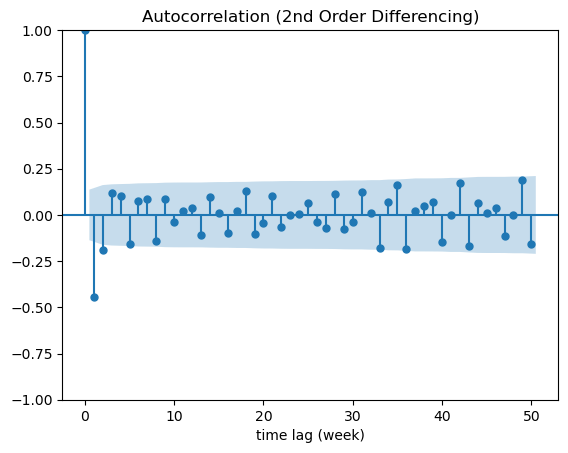

In [52]:
# Auto Correlation for 2nd Order Differencing
plot_acf(df.lag2[2:-1],lags=50)
pyplot.xlabel("time lag (week)")
pyplot.title("Autocorrelation (2nd Order Differencing)")
pyplot.show()

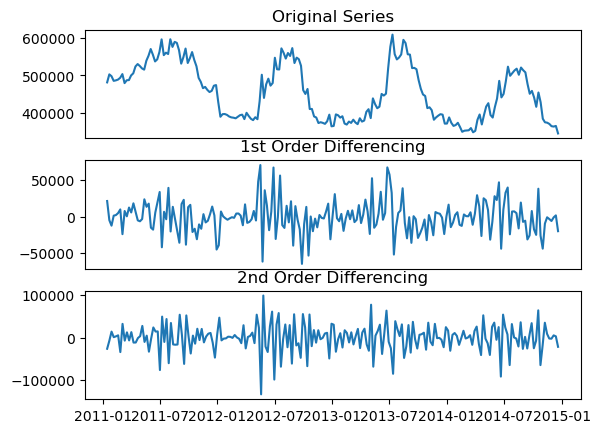

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df.avg); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df.lag1); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df.lag2); ax3.set_title('2nd Order Differencing')
plt.show()

In [279]:
# Create Features that Account for Year, Month, Day
df["Year"] = df.index.year
df["Month"] = df.index.month
df["Day"] = df.index.day
df

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_368,MT_369,MT_370,avg,Holiday,lag1,lag2,Year,Month,Day
Time,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000000e+00,481527.477720,1,NaN,NaN,2011,1,1
2011-01-08,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000000e+00,502951.345669,0,21423.867949,NaN,2011,1,8
2011-01-15,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000000e+00,498078.529789,1,-4872.815880,-26296.683829,2011,1,15
2011-01-22,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000000e+00,485628.908587,0,-12449.621202,-7576.805322,2011,1,22
2011-01-29,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000000e+00,486920.453124,0,1291.544536,13741.165738,2011,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-22,1431.432,15495.055,1150.529,85875.982,39807.318,136717.273,3111.885,172531.814,35543.749,45292.476,...,83380.628,513220.675,1.177692e+07,370590.632546,1,-3324.928625,-2362.069524,2014,11,22
2014-11-29,1398.438,15648.680,1150.529,88241.860,41308.538,141267.868,3157.081,174073.900,36101.454,40534.392,...,86247.081,505414.208,1.193795e+07,364544.260878,0,-6046.371668,-2721.443044,2014,11,29
2014-12-06,1407.321,15445.965,1150.529,93160.551,46463.447,153059.528,3500.250,180164.805,39653.890,42175.268,...,82808.008,503136.374,1.206768e+07,363506.206518,0,-1038.054359,5008.317309,2014,12,6


## Train Validation Test Split

In [280]:
# Split data set by 80%, 10%, 10%
train = df.loc[:'2014-03-15']
val   = df.loc['2014-03-15':'2014-08-09']
test  = df.loc['2014-08-09':'2014-12-20']

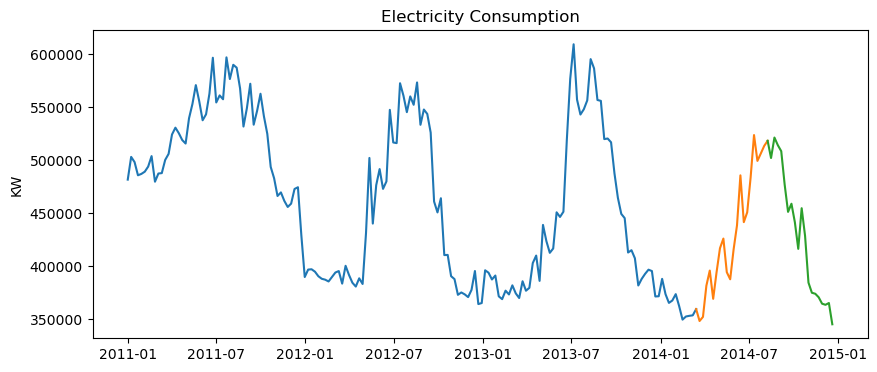

In [281]:
# Time Series
plt.subplots(figsize=(10, 4))
plt.plot(train.avg)
plt.plot(val.avg)
plt.plot(test.avg)
plt.title('Electricity Consumption')
plt.ylabel('KW')
plt.show()

## Modeling

In [74]:
# Define MAPE
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
# Validation Index
start_index = '2014-03-15'
end_index = '2014-08-09'

In [ ]:
# Split data
x_train = train[['Holiday','Month','Year','Day']]
y_train = train['avg']
x_val = val[['Holiday','Month','Year','Day']]
y_val = val['avg']
x_test = test[['Holiday','Month','Year','Day']]
y_test = test['avg']

### Linear Regression

In [299]:
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
print('Intercept:', regr.intercept_)
print('Coefficients:', regr.coef_)

Intercept: 81329759.14726946
Coefficients: [-28533.39686444   3058.19207658 -40196.4980472     -52.88822096]


In [295]:
print('The MAPE for Linear regression is:', round(mape(regr.predict(x_val), y_val),2),'%')

The MAPE for Linear regression is: 14.02 %


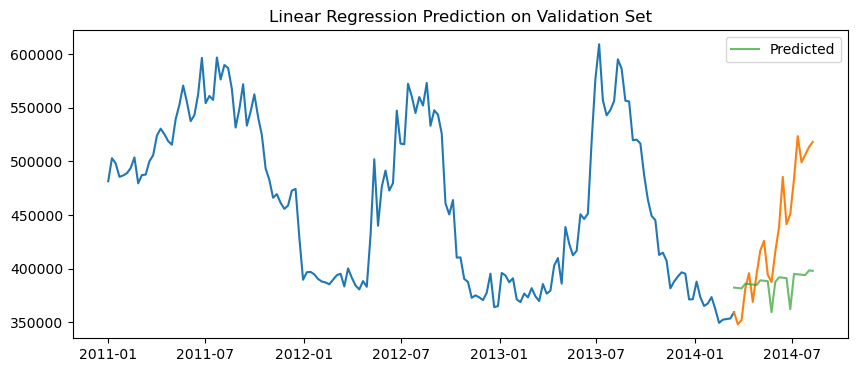

In [309]:
# Plot Linear Regression Prediction on Validation Set
plt.subplots(figsize=(10, 4))
plt.plot(train.avg)
plt.plot(val.avg)
plt.plot(val.index, regr.predict(x_val), label='Predicted', alpha=.7)
ax.set_ylabel('KW')
plt.legend()
plt.title('Linear Regression Prediction on Validation Set')
plt.show()

### Random Forest

In [290]:
rf_reg = RandomForestRegressor().fit(x_train,y_train)
y_pred = rf_reg.predict(x_val)

In [292]:
print("The MAPE for Random Forest Regressor is: ", round(mape(y_val, y_pred),2) ,'%')

The MAPE for Random Forest Regressor is:  8.22 %


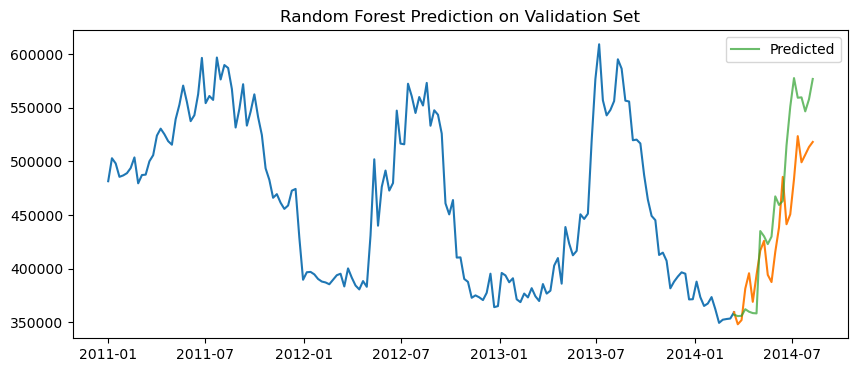

In [310]:
# Plot Random Forest Prediction on Validation Set
plt.subplots(figsize=(10, 4))
plt.plot(train.avg)
plt.plot(val.avg)
plt.plot(val.index, y_pred, label='Predicted', alpha=.7)
ax.set_ylabel('KW')
plt.legend()
plt.title('Random Forest Prediction on Validation Set')
plt.show()

### XGBoost

In [312]:
xgb_reg = XGBRegressor().fit(x_train,y_train)
y_pred = xgb_reg.predict(x_val)

In [313]:
print("The MAPE for XGBoost Regressor is: ", round(mape(y_val, y_pred),2) ,'%')

The MAPE for XGBoost Regressor is:  5.29 %


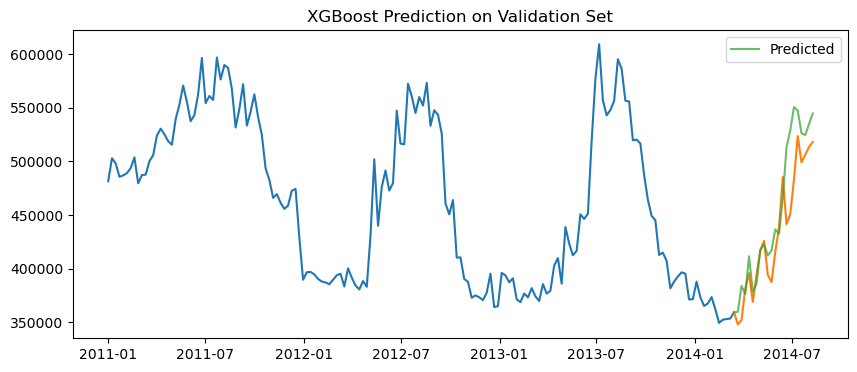

In [315]:
# Plot XGBoost Prediction on Validation Set
plt.subplots(figsize=(10, 4))
plt.plot(train.avg)
plt.plot(val.avg)
plt.plot(val.index, y_pred, label='Predicted', alpha=.7)
ax.set_ylabel('KW')
plt.legend()
plt.title('XGBoost Prediction on Validation Set')
plt.show()

### Adaboost

In [318]:
ada_reg = AdaBoostRegressor().fit(x_train,y_train)
y_pred = ada_reg.predict(x_val)

In [319]:
print("The MAPE for AdaBoost Regressor is: ", round(mape(y_val, y_pred),2) ,'%')

The MAPE for AdaBoost Regressor is:  7.47 %


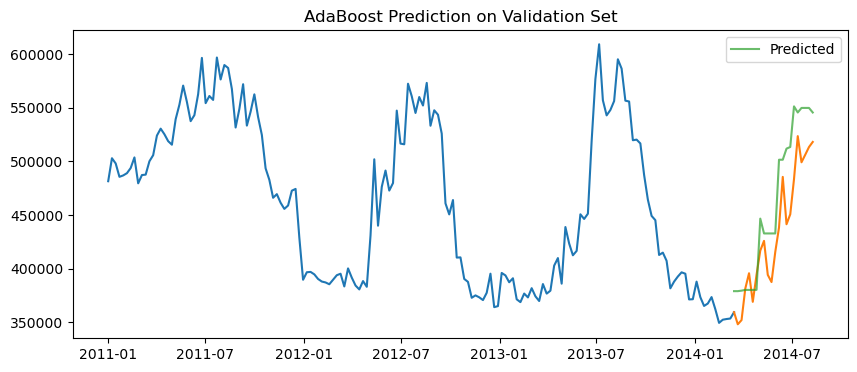

In [320]:
# Plot AdaBoost Prediction on Validation Set
plt.subplots(figsize=(10, 4))
plt.plot(train.avg)
plt.plot(val.avg)
plt.plot(val.index, y_pred, label='Predicted', alpha=.7)
ax.set_ylabel('KW')
plt.legend()
plt.title('AdaBoost Prediction on Validation Set')
plt.show()

### SARIMA

In [257]:
mod_b = sm.tsa.statespace.SARIMAX(train.avg,
                                  order=(4,1,2),
                                  seasonal_order=(1,1,1,52),
#                                 enforce_stationarity=False,
                                  enforce_invertibility=False) 

In [258]:
# Print Model Summary
sarimax_fit_b = mod_b.fit(disp=0)
print(sarimax_fit_b.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  avg   No. Observations:                  168
Model:             SARIMAX(4, 1, 2)x(1, 1, [1], 52)   Log Likelihood               -1328.671
Date:                              Tue, 28 Feb 2023   AIC                           2675.342
Time:                                      21:11:07   BIC                           2700.047
Sample:                                  01-01-2011   HQIC                          2685.370
                                       - 03-15-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0672      0.687      0.098      0.922      -1.278       1.413
ar.L2          0.82

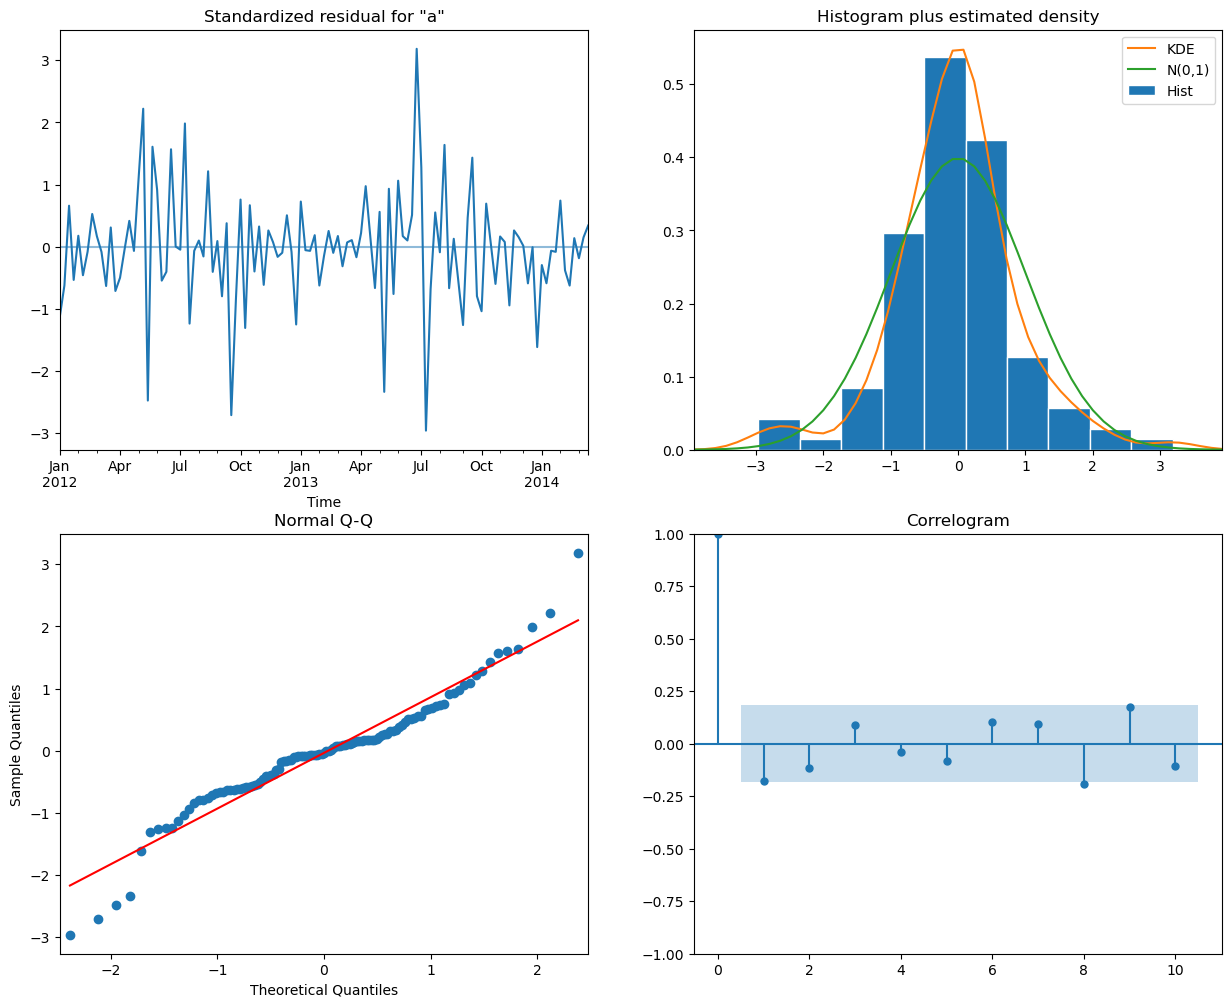

In [259]:
# Plot Diagnostics
sarimax_fit_b.plot_diagnostics(figsize=(15, 12))
plt.show()

In [269]:
pred_b = sarimax_fit_b.get_prediction(start_index, end_index, dynamic=False)
print('The MAPE for SARIMA model is:', round(mape(val.avg, pred_b.predicted_mean),2),'%')

The MAPE for SARIMA model is: 4.64 %


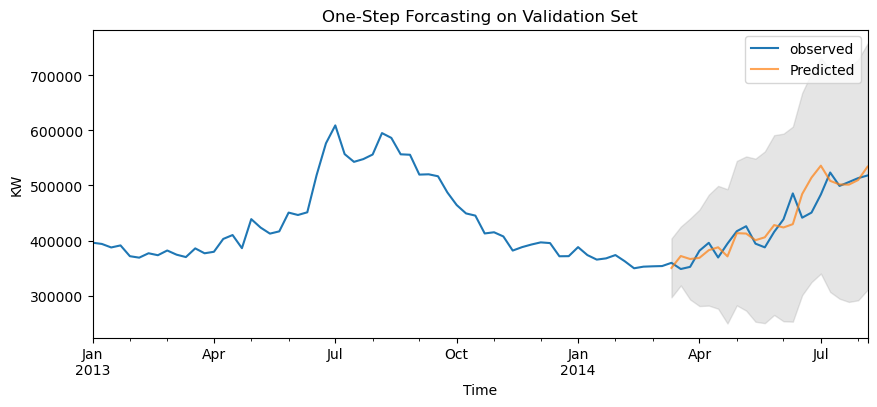

In [261]:
# Plot One-Step Forcasting on Validation Set
pred_ci_b = pred_b.conf_int()
ax = df['2013-01-05':'2014-08-09'].avg.plot(label='observed', figsize=(10, 4))
pred_b.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7)
ax.fill_between(pred_ci_b.index,pred_ci_b.iloc[:, 0],pred_ci_b.iloc[:, 1], color='grey', alpha=.2)
ax.set_ylabel('KW')
plt.legend()
plt.title('One-Step Forcasting on Validation Set')
plt.show()

### SARIMAX

In [262]:
mod = sm.tsa.statespace.SARIMAX(train.avg,
                                exog = train.Holiday,
                                order=(4,1,2),
                                seasonal_order=(1,1,1,52),
                                enforce_invertibility=False)

In [263]:
sarimax_fit = mod.fit(disp=0)
pred = sarimax_fit.get_prediction(start_index, end_index, exog = val.Holiday[:-1], dynamic=False)

In [268]:
print('The MAPE for SARIMAX model is:', round(mape(val.avg, pred.predicted_mean),2),'%')

The MAPE for SARIMAX model is: 4.64 %


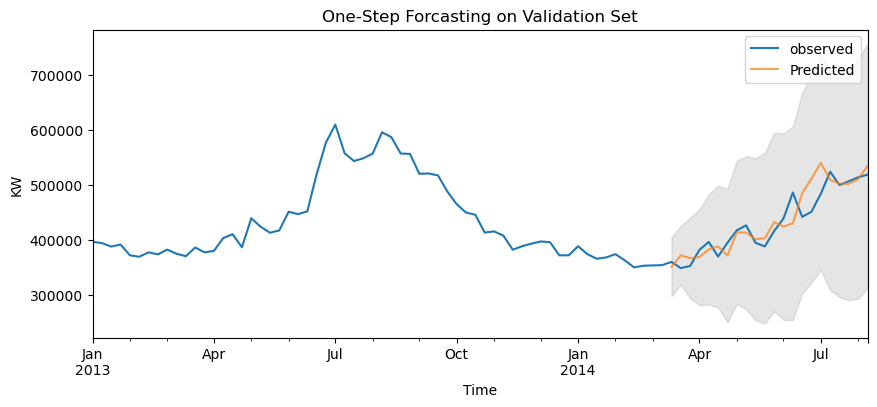

In [265]:
# Plot One-Step Forcasting on Validation Set
pred_ci = pred.conf_int()
ax = df['2013-01-05':'2014-08-09'].avg.plot(label='observed', figsize=(10, 4))
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='grey', alpha=.2)
ax.set_ylabel('KW')
plt.legend()
plt.title('One-Step Forcasting on Validation Set')
plt.show()

## Hyperparameter Tuning

In [103]:
#grid search finding best p,q with 52 as s
#resulting best: p=6, q=6

MAPES = []

#grid search to find min MAPE

for p in [2, 4, 6, 13]:
    for q in [2, 3, 4, 6]:
        mod_x = sm.tsa.statespace.SARIMAX(train.avg,
                                          order=(p,1,q),
                                          exog = train.Holiday,
                                          seasonal_order=(1,1,1,52),
                                          enforce_invertibility=False)
        sarimax_fit_x = mod_x.fit(disp=0)
        pred_x = sarimax_fit_x.get_prediction(start_index, end_index, exog = val.Holiday[:-1], dynamic=False)
        metric = round(mape(val.avg, pred_x.predicted_mean),4)
        print('The MAPE for SARIMAX model is:', 'where p=', p,'where q=',q,round(mape(val.avg, pred_x.predicted_mean),4),'%')
        MAPES.append(metric)

min(MAPES)

The MAPE for SARIMAX model is: where p= 2 where q= 2 4.5984 %
The MAPE for SARIMAX model is: where p= 2 where q= 3 4.6451 %
The MAPE for SARIMAX model is: where p= 2 where q= 4 4.6321 %
The MAPE for SARIMAX model is: where p= 2 where q= 6 4.5634 %
The MAPE for SARIMAX model is: where p= 4 where q= 2 4.6366 %
The MAPE for SARIMAX model is: where p= 4 where q= 3 4.644 %
The MAPE for SARIMAX model is: where p= 4 where q= 4 4.7079 %
The MAPE for SARIMAX model is: where p= 4 where q= 6 4.5978 %
The MAPE for SARIMAX model is: where p= 6 where q= 2 4.7237 %
The MAPE for SARIMAX model is: where p= 6 where q= 3 99.9218 %
The MAPE for SARIMAX model is: where p= 6 where q= 4 4.6847 %
The MAPE for SARIMAX model is: where p= 6 where q= 6 4.3096 %
The MAPE for SARIMAX model is: where p= 13 where q= 2 4.5793 %
The MAPE for SARIMAX model is: where p= 13 where q= 3 5.852 %
The MAPE for SARIMAX model is: where p= 13 where q= 4 5.3142 %
The MAPE for SARIMAX model is: where p= 13 where q= 6 4.84 %


4.3096

### Best Model

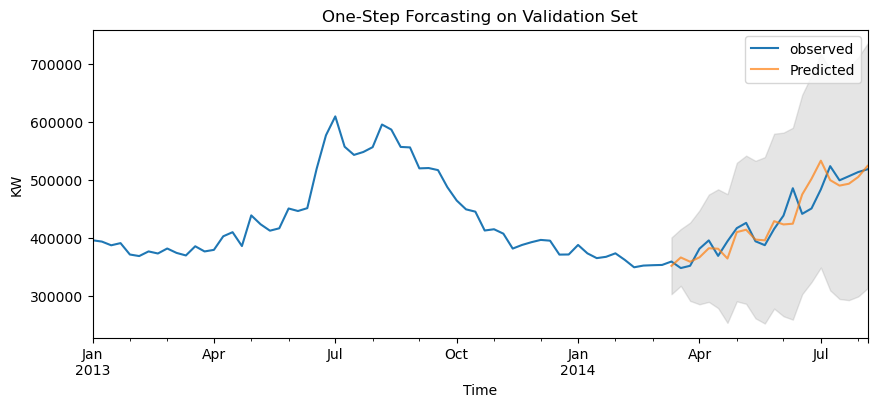

In [120]:
mod_f = sm.tsa.statespace.SARIMAX(train.avg,
                                  exog = train.Holiday,
                                  order=(6,1,6),
                                  seasonal_order=(1,1,1,52),
                                  enforce_invertibility=False)

sarimax_fit_f = mod_f.fit(disp=0)
pred_f = sarimax_fit_f.get_prediction(start_index, end_index, exog = val.Holiday[:-1], dynamic=False)

# Plot One-Step Forcasting on Validation Set
pred_ci_f = pred_f.conf_int()
ax = df['2013-01-05':'2014-08-09'].avg.plot(label='observed', figsize=(10, 4))
pred_f.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7)
ax.fill_between(pred_ci_f.index,pred_ci_f.iloc[:, 0],pred_ci_f.iloc[:, 1], color='grey', alpha=.2)
ax.set_ylabel('KW')
plt.legend()
plt.title('One-Step Forcasting on Validation Set')
plt.show()

In [270]:
print('The MAPE for SARIMAX model is:', round(mape(val.avg, pred_f.predicted_mean),2),'%')

The MAPE for SARIMAX model is: 4.31 %


## Predict on Test Data

In [127]:
# Test Index
test_start_index = '2014-08-09'
test_end_index = '2014-12-20'

In [152]:
pred_t = sarimax_fit_f.get_prediction('2014-08-09','2014-12-20', 
                                      exog = pd.concat([val.Holiday[:-1], test.Holiday])[:-1],
                                      dynamic = False)

In [271]:
print('The MAPE for SARIMAX model is:', round(mape(test.avg, pred_t.predicted_mean),2),'%')

The MAPE for SARIMAX model is: 3.24 %


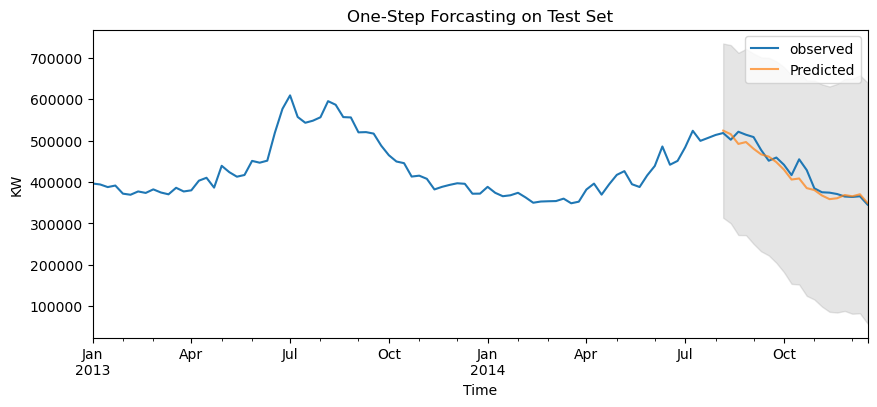

In [155]:
# Plot One-Step Forcasting on Test Set
pred_ci_t = pred_t.conf_int()
ax = df['2013-01-05':'2014-12-20'].avg.plot(label='observed', figsize=(10, 4))
pred_t.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7)
ax.fill_between(pred_ci_t.index,pred_ci_t.iloc[:, 0],pred_ci_t.iloc[:, 1], color='grey', alpha=.2)
ax.set_ylabel('KW')
plt.legend()
plt.title('One-Step Forcasting on Test Set')
plt.show()

### Test Result Divided into Time Perieds

In [157]:
test.index

DatetimeIndex(['2014-08-09', '2014-08-16', '2014-08-23', '2014-08-30',
               '2014-09-06', '2014-09-13', '2014-09-20', '2014-09-27',
               '2014-10-04', '2014-10-11', '2014-10-18', '2014-10-25',
               '2014-11-01', '2014-11-08', '2014-11-15', '2014-11-22',
               '2014-11-29', '2014-12-06', '2014-12-13', '2014-12-20'],
              dtype='datetime64[ns]', name='Time', freq='W-SAT')

In [272]:
print('The MAPE for 2014-08-09 to 2014-09-12 is:', round(mape(test.avg[0:5], pred_t.predicted_mean[0:5]),2),'%')

The MAPE for 2014-08-09 to 2014-09-12 is: 3.69 %


In [273]:
print('The MAPE for 2014-09-13 to 2014-10-17 is:', round(mape(test.avg[5:10], pred_t.predicted_mean[5:10]),2),'%')

The MAPE for 2014-09-13 to 2014-10-17 is: 2.41 %


In [274]:
print('The MAPE for 2014-10-18 to 2014-11-21 is:', round(mape(test.avg[10:15], pred_t.predicted_mean[10:15]),2),'%')

The MAPE for 2014-10-18 to 2014-11-21 is: 5.55 %


In [275]:
print('The MAPE for 2014-11-22 to 2014-12-26 is:', round(mape(test.avg[15:20], pred_t.predicted_mean[15:20]),2),'%')

The MAPE for 2014-11-22 to 2014-12-26 is: 1.32 %


In [171]:
# Calculate Error
def error(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.abs((actual - pred) / actual) * 100

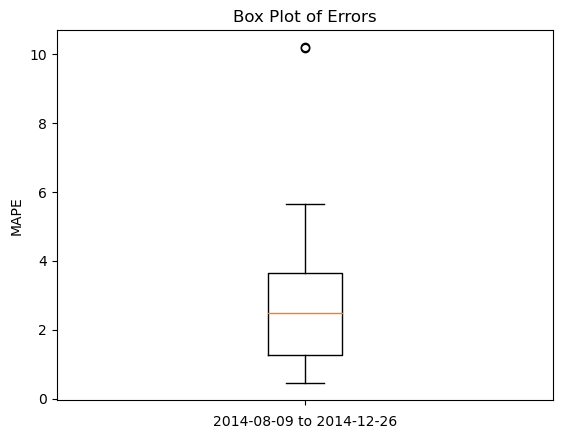

In [222]:
plt.boxplot(error(test.avg, pred_t.predicted_mean))
plt.ylabel("MAPE")
plt.xlabel("2014-08-09 to 2014-12-26")
plt.xticks([1],'')
plt.title('Box Plot of Errors')
plt.show()

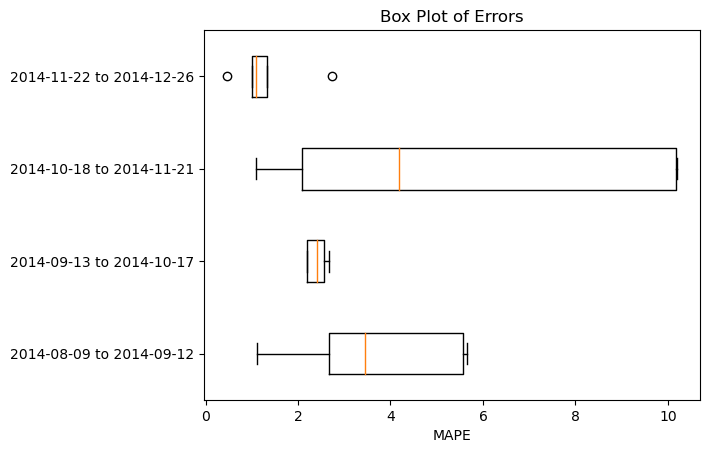

In [220]:
e = [error(test.avg[0:5], pred_t.predicted_mean[0:5]),error(test.avg[5:10], pred_t.predicted_mean[5:10]),
     error(test.avg[10:15], pred_t.predicted_mean[10:15]),error(test.avg[15:20], pred_t.predicted_mean[15:20])]

tmp = pd.DataFrame()
tmp['error'] = [error(test.avg[0:5], pred_t.predicted_mean[0:5]),
                error(test.avg[5:10], pred_t.predicted_mean[5:10]),
                error(test.avg[10:15], pred_t.predicted_mean[10:15]),
                error(test.avg[15:20], pred_t.predicted_mean[15:20])]
tmp['slot'] = ["2014-08-09 to 2014-09-12", "2014-09-13 to 2014-10-17", 
               "2014-10-18 to 2014-11-21", "2014-11-22 to 2014-12-26"]

plt.boxplot(tmp.error, vert=False)
plt.xlabel("MAPE")
plt.yticks([1,2,3,4],tmp.slot)
plt.title('Box Plot of Errors')
plt.show()